In [1]:
import pdspy.modeling as modeling
import pdspy.dust as dust
import numpy
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import glob

In [2]:
# starting values

T_star = 4000.     #0
logL_star = 1.     #1
logM_disk = -5.    #2
logR_disk = 1.5    #3
h_0 = 0.2          #4
logR_in = 1.       #5
gamma = 1.         #6
beta = 1.2         #7
logM_env = -5.     #8
logR_env = 3.2     #9
f_cav = 0.5        #10
ksi = 1.           #11
loga_max = 3.      #12
p = 3.5            #13
incl = 45.         #14

In [3]:
params = [T_star,logL_star,logM_disk,logR_disk,h_0,logR_in,\
          gamma,beta,logM_env,logR_env,f_cav,ksi,loga_max,p,incl]
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
base = [4000., 1., -5., 1.5, 0.2, 1., 1., 1.2, -5., 3.2, 0.5, 1., 3., 3.5, 45.]

In [4]:
filenames=[]
for i in range(len(param_names)):
    sub=[]
    for j in range(7):
        sub.append(param_names[i]+"_"+str(j)+'.hdf5')
    filenames.append(sub)

In [ ]:
def stacked_SEDs(i):
    num=3
    steps=numpy.linspace(ranges[i][0],ranges[i][1],num)
    for j in range(len(params)):
        params[j]=base[j]
    for k in range(len(steps)):
        params[i]=steps[k]
        
        #dust properties
        dust_gen = dust.DustGenerator(dust.__path__[0]+"/data/diana_wice.hdf5")
        ddust = dust_gen(10.**params[12]/ 1e4, params[13])
        env_dust_gen = dust.DustGenerator(dust.__path__[0]+\
                "/data/diana_wice.hdf5")
        edust = env_dust_gen(1.0e-4, 3.5)
        
        #alpha
        alpha=params[6]+params[7]
        
        # fix scale height of disk       
        params[4] *= (10.**params[3])**params[7]
        
        # Set up the model.
        model = modeling.YSOModel()
        model.add_star(luminosity=10.**params[1], temperature=params[0])
        model.set_spherical_grid(10.**params[5], 10.**params[9], 100, 101, 2, \
                code="radmc3d")
        model.add_pringle_disk(mass=10.**params[2], rmin=10.**params[5], \
                rmax=10.**params[3], plrho=alpha, h0=params[4], plh=params[7], dust=ddust)
        model.add_ulrich_envelope(mass=10.**params[8], rmin=10.**params[5], \
                rmax=10.**params[9], cavpl=params[11], cavrfact=params[10], dust=edust)
        model.grid.set_wavelength_grid(0.1,1.0e5,500,log=True)
        
        print("finished setting up model, now running SED and image")
        
        # Run the thermal simulation
        model.run_thermal(code="radmc3d", nphot=1e6, \
                modified_random_walk=True, verbose=False, setthreads=15, \
                timelimit=10800)
        # Run the SED
        model.set_camera_wavelength(numpy.logspace(-1.,4.,500))
        model.run_sed(name="SED", nphot=1e5, loadlambda=True, incl=params[14], \
                pa=0., dpc=140., code="radmc3d", camera_scatsrc_allfreq=True, \
                verbose=False, setthreads=15)

        # Write out the file.
        model.write_yso("./hdf5/"+filenames[i][k])
        
        print("model generated for ",param_names[i],"=",steps[k])
    
    # stacked plot
    
    interval=numpy.linspace(0.,1.,len(steps))
    colors= plt.cm.viridis(interval)

    pdf = PdfPages("./comp"+str(len(steps))+"/"+param_names[i]+"_"+str(len(steps))+".pdf")

    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(len(steps)):
        model = modeling.YSOModel()
        model.read_yso("./hdf5/"+filenames[i][m])
        ax.loglog(model.spectra["SED"].wave, model.spectra["SED"].flux, "-",color=colors[m], label=param_names[i]+"="+str(steps[m]))

    ax.set_ylim(1.0e-6,1.0e5)

    plt.legend()
    plt.title(param_names[i])
    plt.ylabel("Flux Density (mJy)")
    plt.xlabel("λ (μm)")
    plt.show()

    # Now save the figure.
    pdf.savefig(fig)
    plt.clf()

    # close pdf
    pdf.close()
    print("stacked comparison plot generated for", param_names[i])

In [ ]:
for i in range(len(params)):
    stacked_SEDs(i)

In [ ]:
def SEDs_only(i):
    num=3
    steps=numpy.linspace(ranges[i][0],ranges[i][1],num)
    # stacked plot
    
    interval=numpy.linspace(0.,1.,len(steps))
    colors= plt.cm.viridis(interval)

    pdf = PdfPages("../visualization/SED/comp"+str(len(steps))+"/"+param_names[i]+"_"+str(len(steps))+".pdf")

    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(len(steps)):
        model = modeling.YSOModel()
        model.read_yso("../old/hdf5/"+filenames[i][m])
        ax.loglog(model.spectra["SED"].wave, model.spectra["SED"].flux, "-",color=colors[m], label=param_names[i]+"="+str(steps[m]))

    ax.set_ylim(1.0e-6,1.0e5)

    plt.legend()
    plt.title(param_names[i])
    plt.ylabel("Flux Density (mJy)")
    plt.xlabel("λ (μm)")
    plt.show()

    # Now save the figure.
    pdf.savefig(fig)
    plt.clf()

    # close pdf
    pdf.close()
    print("stacked comparison plot generated for", param_names[i])

In [10]:
filenames10=[]
for i in range(len(param_names)):
    sub=[]
    for j in range(7):
        sub.append(param_names[i]+"_"+str(j)+'_10.hdf5')
    filenames10.append(sub)

In [12]:
def SEDs_only10(i):
    num=3
    steps=numpy.linspace(ranges[i][0],ranges[i][1],num)
    # stacked plot
    
    interval=numpy.linspace(0.,1.,len(steps))
    colors= plt.cm.viridis(interval)

    pdf = PdfPages("../visualization/SED/"+param_names[i]+"_SED_"+str(len(steps))+"_10.pdf")

    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(len(steps)):
        model = modeling.YSOModel()
        model.read_yso("../old/hdf5/"+filenames10[i][m])
        ax.loglog(model.spectra["SED"].wave, model.spectra["SED"].flux, "-",color=colors[m], label=param_names[i]+"="+str(steps[m]))

    ax.set_ylim(1.0e-6,1.0e5)

    plt.legend()
    plt.title(param_names[i])
    plt.ylabel("Flux Density (mJy)")
    plt.xlabel("λ (μm)")
    plt.show()

    # Now save the figure.
    pdf.savefig(fig)
    plt.clf()

    # close pdf
    pdf.close()
    print("stacked comparison plot generated for", param_names[i])

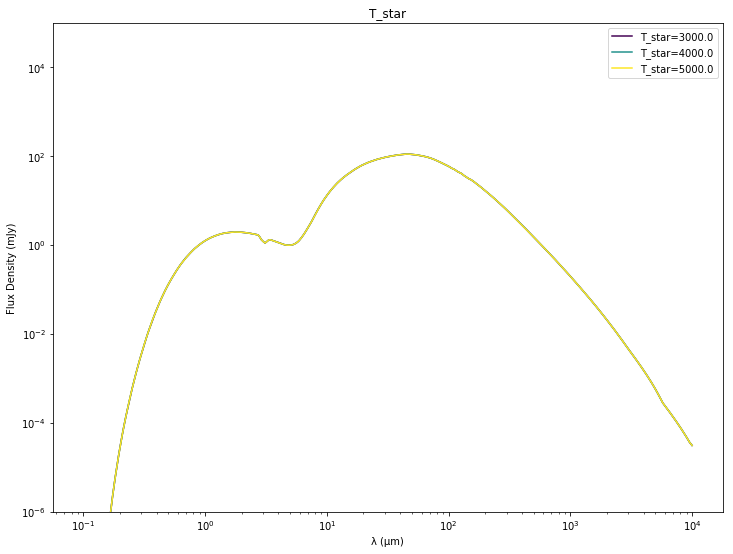

stacked comparison plot generated for T_star


<Figure size 432x288 with 0 Axes>

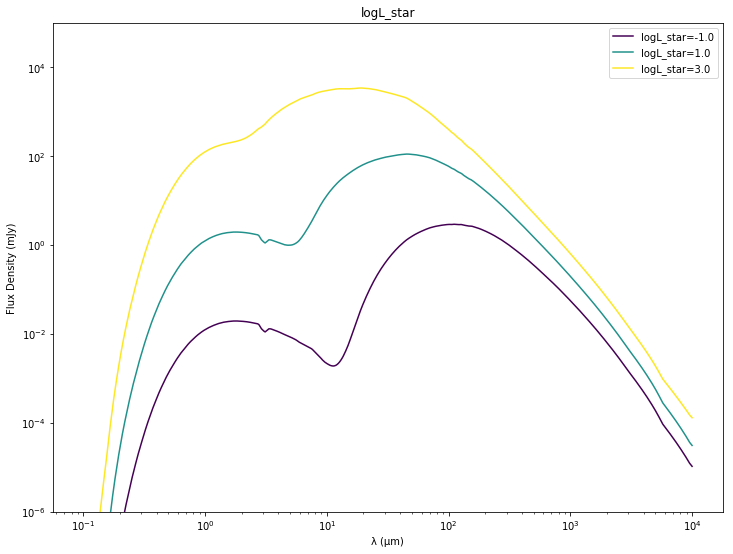

stacked comparison plot generated for logL_star


<Figure size 432x288 with 0 Axes>

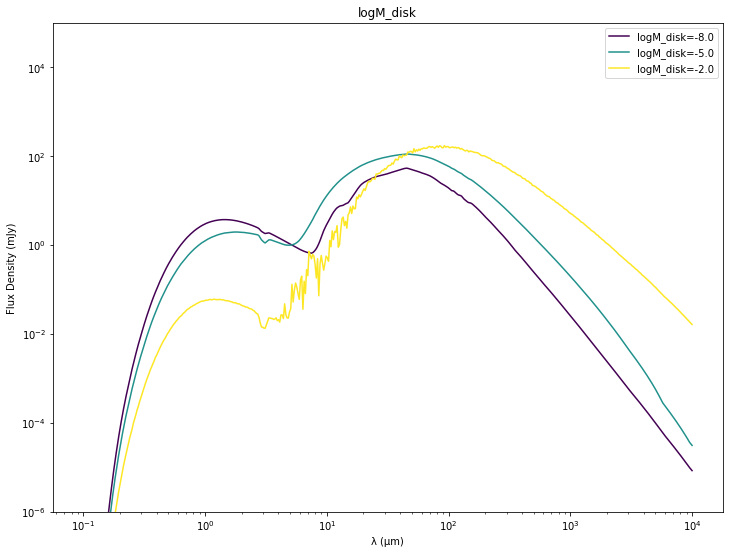

stacked comparison plot generated for logM_disk


<Figure size 432x288 with 0 Axes>

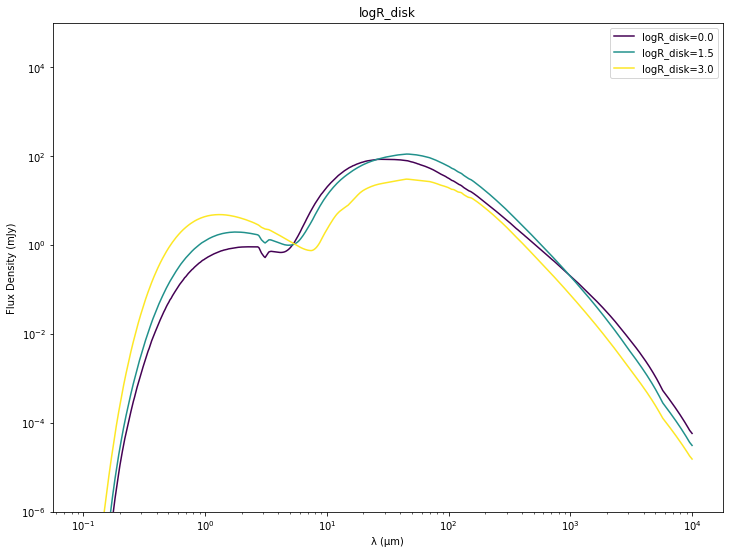

stacked comparison plot generated for logR_disk


<Figure size 432x288 with 0 Axes>

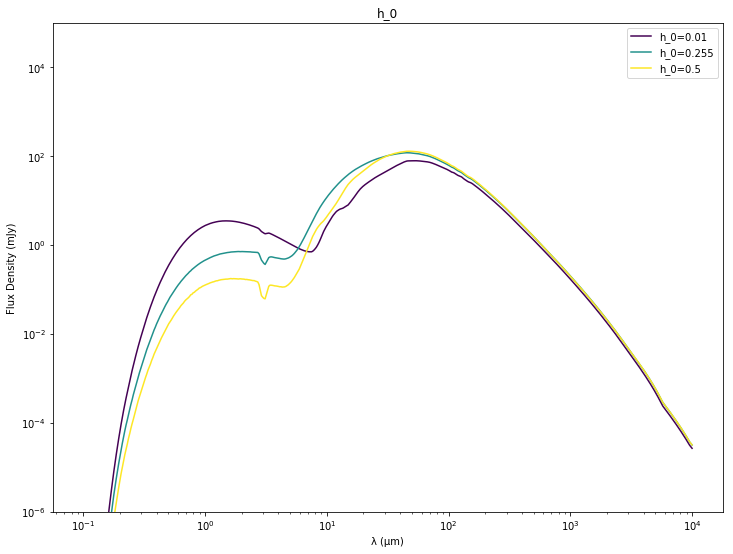

stacked comparison plot generated for h_0


<Figure size 432x288 with 0 Axes>

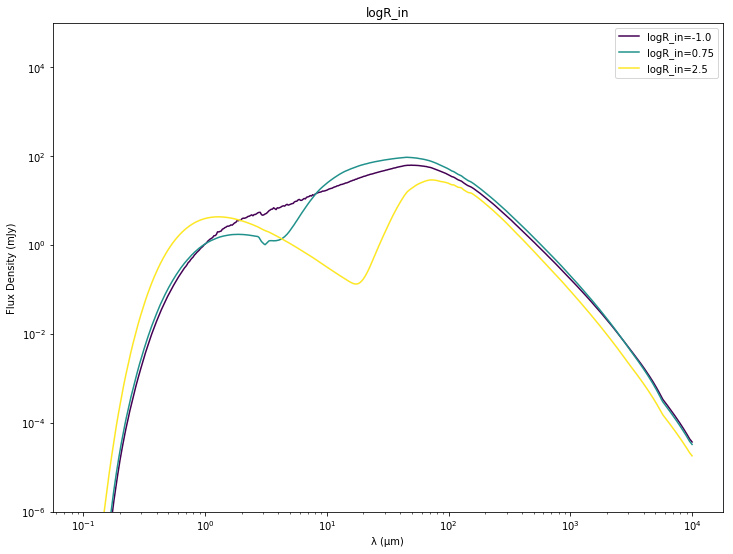

stacked comparison plot generated for logR_in


<Figure size 432x288 with 0 Axes>

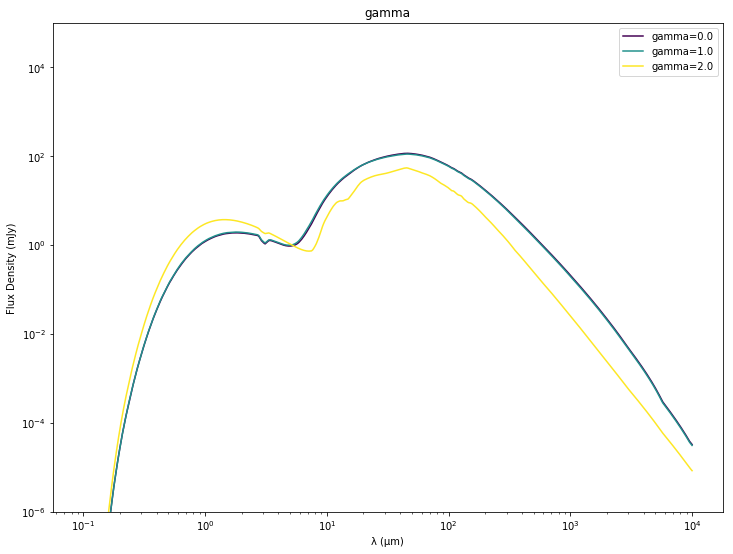

stacked comparison plot generated for gamma


<Figure size 432x288 with 0 Axes>

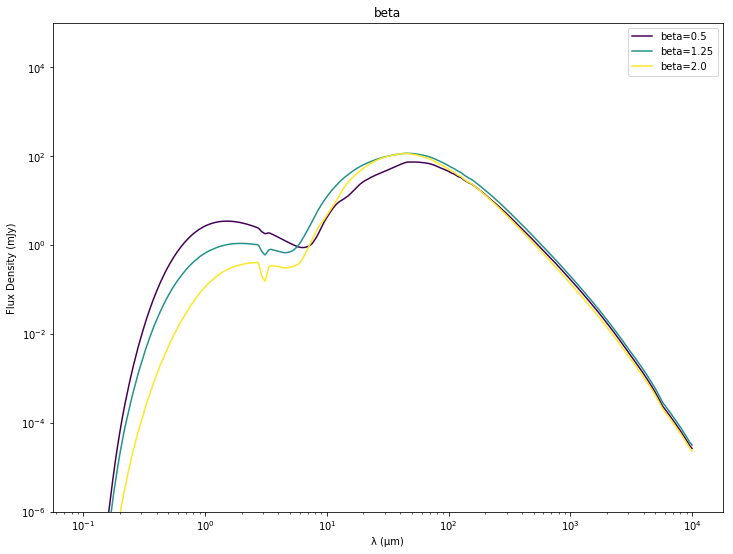

stacked comparison plot generated for beta


<Figure size 432x288 with 0 Axes>

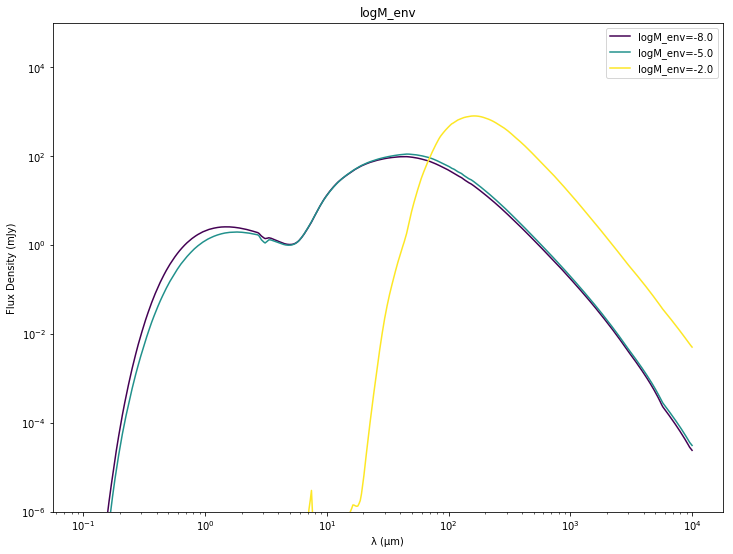

stacked comparison plot generated for logM_env


<Figure size 432x288 with 0 Axes>

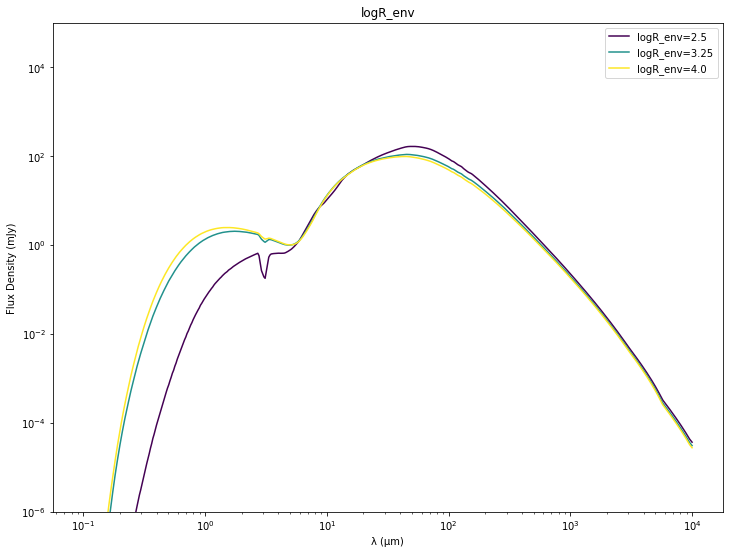

stacked comparison plot generated for logR_env


<Figure size 432x288 with 0 Axes>

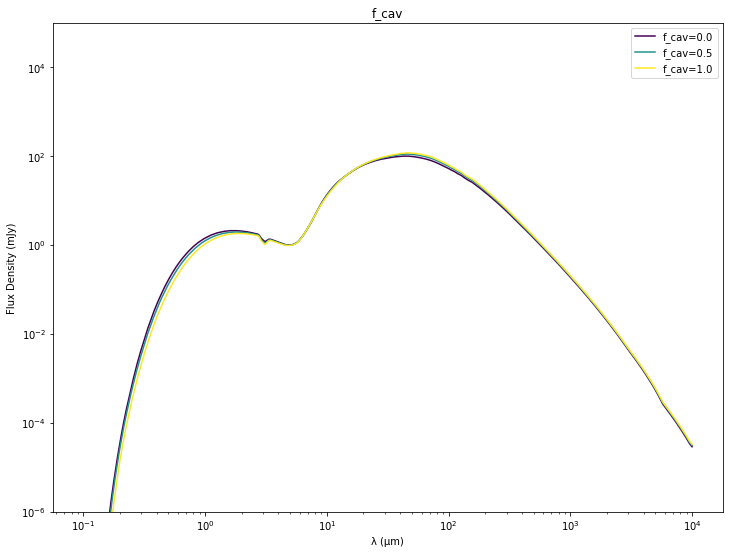

stacked comparison plot generated for f_cav


<Figure size 432x288 with 0 Axes>

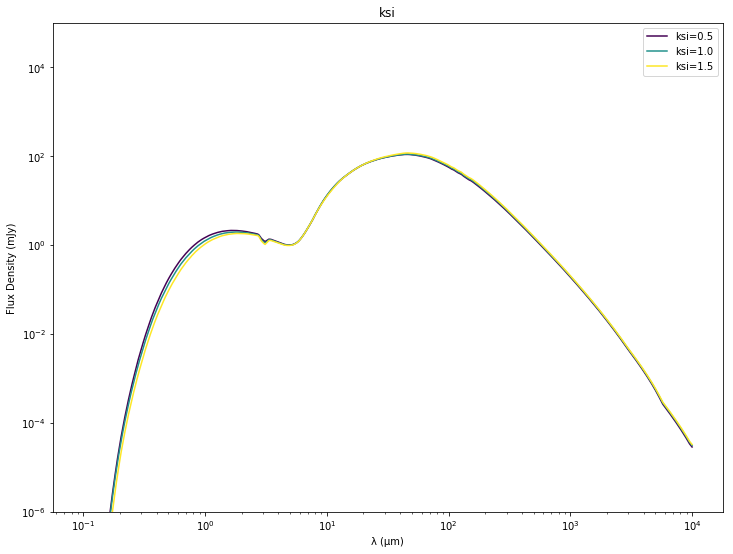

stacked comparison plot generated for ksi


<Figure size 432x288 with 0 Axes>

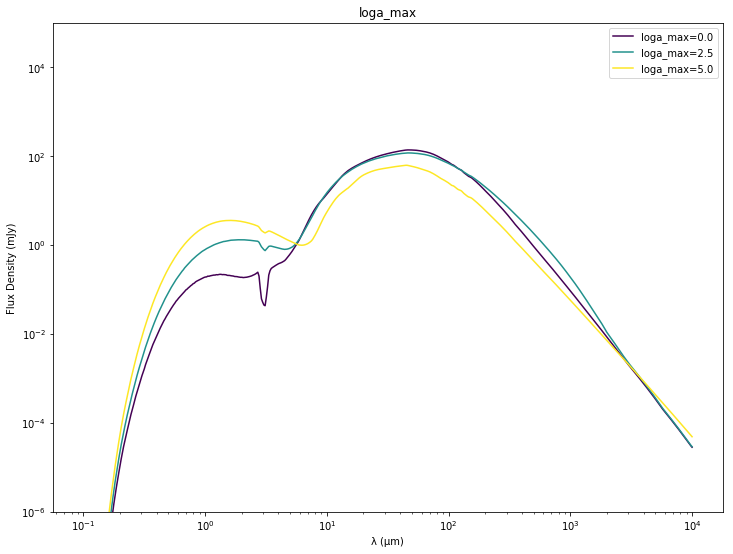

stacked comparison plot generated for loga_max


<Figure size 432x288 with 0 Axes>

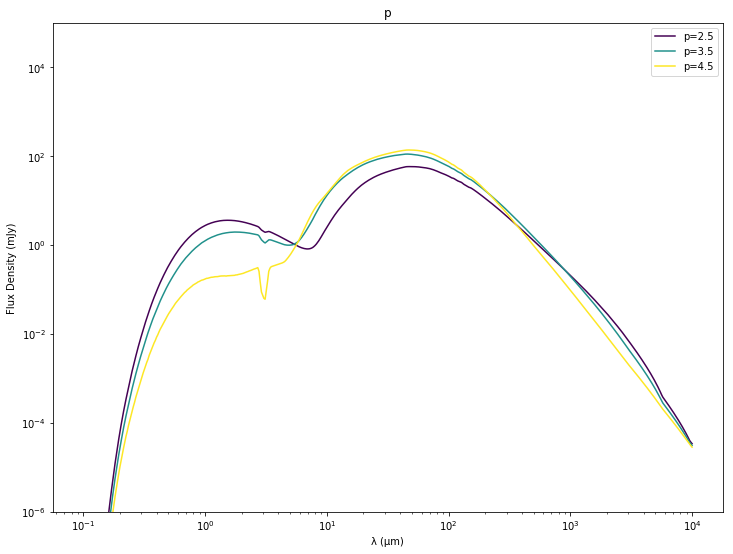

stacked comparison plot generated for p


<Figure size 432x288 with 0 Axes>

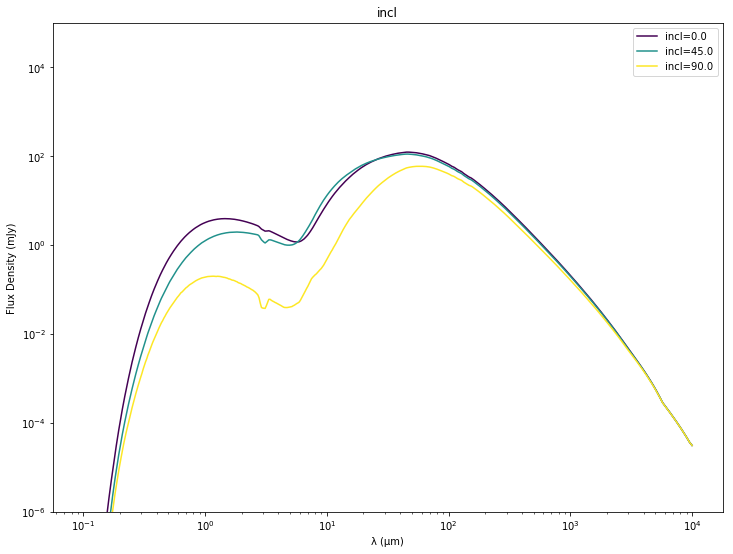

stacked comparison plot generated for incl


<Figure size 432x288 with 0 Axes>

In [13]:
for i in range(len(params)):
    SEDs_only10(i)

In [ ]:
for i in range(len(params)):
    SEDs_only(i)

In [5]:
filenames10=[]
for i in range(len(param_names)):
    sub=[]
    for j in range(7):
        sub.append(param_names[i]+"_"+str(j)+'_10.hdf5')
    filenames10.append(sub)

In [6]:
def run_yso_model(filename=None, Tstar=None, logL_star=None, \
        logM_disk=None, logR_disk=None, h_0=None, logR_in=None, beta=None, \
        gamma=None, logM_env=None, logR_env=None, f_cav=None, ksi=None, \
        loga_max=None, p=None, incl=None):

    # Set up the dust properties.

    dust_gen = dust.DustGenerator(dust.__path__[0]+"/data/diana_wice.hdf5")
    ddust = dust_gen(10.**loga_max / 1e4, p)
    env_dust_gen = dust.DustGenerator(dust.__path__[0]+\
            "/data/diana_wice.hdf5")
    edust = env_dust_gen(1.0e-4, 3.5)

    # Calculate alpha correctly.

    alpha = gamma + beta

    # Fix the scale height of the disk.

    h_0 *= (10.**logR_disk)**beta

    # Set up the model.

    model = modeling.YSOModel()
    model.add_star(luminosity=10.**logL_star, temperature=T_star)
    model.set_spherical_grid(10.**logR_in, 10.**logR_env, 100, 101, 2, \
            code="radmc3d")
    model.add_pringle_disk(mass=10.**logM_disk, rmin=10.**logR_in, \
            rmax=10.**logR_disk, plrho=alpha, h0=h_0, plh=beta, dust=ddust)
    model.add_ulrich_envelope(mass=10.**logM_env, rmin=10.**logR_in, \
            rmax=10.**logR_env, cavpl=ksi, cavrfact=f_cav, dust=edust)
    model.grid.set_wavelength_grid(0.1,1.0e5,500,log=True)
    
    print("finished setting up model, now running thermal simulation, SED, image")
    
    # Run the thermal simulation.
    model.run_thermal(code="radmc3d", nphot=1e6, \
            modified_random_walk=True, verbose=False, setthreads=15, \
            timelimit=10800)

    # Run the SED.

    model.set_camera_wavelength(numpy.logspace(-1.,4.,500))

    model.run_sed(name="SED", nphot=1e5, loadlambda=True, incl=incl, \
            pa=0., dpc=140., code="radmc3d", camera_scatsrc_allfreq=True, \
            verbose=False, setthreads=15)
    # run the image
    model.run_image(name="1mm", nphot=1e5, npix=512, \
            pixelsize=0.05, lam="1000", incl=0., pa=0.,\
            dpc=140, verbose=True)
        
    # Write out the file.
    model.write_yso("../old/hdf5/"+filename)

In [7]:
def models_only(i):
    num=3
    steps=numpy.linspace(ranges[i][0],ranges[i][1],num)
    for j in range(len(params)):
        params[j]=base[j]
    for k in range(len(steps)):
        params[i]=steps[k]
        
        run_yso_model(filename=filenames10[i][k], Tstar=params[0], logL_star=params[1], \
        logM_disk=params[2], logR_disk=params[3], h_0=params[4], logR_in=params[5], beta=params[7], \
        gamma=params[6], logM_env=params[8], logR_env=params[9], f_cav=params[10], ksi=params[11], \
        loga_max=params[12], p=params[13], incl=params[14])
        
        print("model generated for ",param_names[i],"=",steps[k])

In [8]:
models_only(0)

finished setting up model, now running thermal simulation, SED, image
model generated for  T_star = 3000.0
finished setting up model, now running thermal simulation, SED, image
model generated for  T_star = 4000.0
finished setting up model, now running thermal simulation, SED, image
model generated for  T_star = 5000.0


In [9]:
for i in (range(len(params)-1)):
    models_only(i+1)

finished setting up model, now running thermal simulation, SED, image
model generated for  logL_star = -1.0
finished setting up model, now running thermal simulation, SED, image
model generated for  logL_star = 1.0
finished setting up model, now running thermal simulation, SED, image
model generated for  logL_star = 3.0
finished setting up model, now running thermal simulation, SED, image
model generated for  logM_disk = -8.0
finished setting up model, now running thermal simulation, SED, image
model generated for  logM_disk = -5.0
finished setting up model, now running thermal simulation, SED, image
model generated for  logM_disk = -2.0
finished setting up model, now running thermal simulation, SED, image
model generated for  logR_disk = 0.0
finished setting up model, now running thermal simulation, SED, image
model generated for  logR_disk = 1.5
finished setting up model, now running thermal simulation, SED, image
model generated for  logR_disk = 3.0
finished setting up model, now ru

/users/eteng/anaconda3/lib/python3.7/site-packages/pdspy/modeling/Model.py:299: RuntimeWarning: divide by zero encountered in true_divide
  density.sum(axis=0)
/users/eteng/anaconda3/lib/python3.7/site-packages/pdspy/modeling/Model.py:299: RuntimeWarning: invalid value encountered in true_divide
  density.sum(axis=0)


model generated for  f_cav = 0.0
finished setting up model, now running thermal simulation, SED, image
model generated for  f_cav = 0.5
finished setting up model, now running thermal simulation, SED, image
model generated for  f_cav = 1.0
finished setting up model, now running thermal simulation, SED, image
model generated for  ksi = 0.5
finished setting up model, now running thermal simulation, SED, image
model generated for  ksi = 1.0
finished setting up model, now running thermal simulation, SED, image
model generated for  ksi = 1.5
finished setting up model, now running thermal simulation, SED, image
model generated for  loga_max = 0.0
finished setting up model, now running thermal simulation, SED, image
model generated for  loga_max = 2.5
finished setting up model, now running thermal simulation, SED, image
model generated for  loga_max = 5.0
finished setting up model, now running thermal simulation, SED, image
model generated for  p = 2.5
finished setting up model, now running th